In [4]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
import os
import time

pdb = PDBFile('Structure.pdb')
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)

PDBFile.writeFile(pdb.topology, pdb.positions, open('Structure-opemm.pdb','w'))

checkpoint_file = 'checkpoint.cpt'
overwrite = True
replica = 1

In [5]:
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
simulation = Simulation(pdb.topology, system, integrator)

if os.path.exists(checkpoint_file) and not overwrite:
    with open(checkpoint_file, 'rb') as cpt:
        simulation.context.loadCheckpoint(cpt.read())
        
else:
    simulation.context.setPositions(pdb.positions)    
    simulation.minimizeEnergy()
    
simulation.reporters.append(DCDReporter('output_structure_'+str(replica).zfill(2)+'.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
        potentialEnergy=True, temperature=True))
simulation.reporters.append(CheckpointReporter(checkpoint_file, 1000))
start_time = time.time()
simulation.step(300000)
print('It ran for %s s' % (time.time() - start_time))


#"Step","Potential Energy (kJ/mole)","Temperature (K)"
10000,-1573279.1520679782,301.1891999150847
20000,-1575111.8788817779,300.244845624331
30000,-1575995.0787467118,299.7155280774258
40000,-1574188.150101061,300.36802760577183
50000,-1575028.396619128,301.63205886417296
60000,-1574653.8985005822,299.9492157876133
70000,-1575179.6655556613,299.7645524689393
80000,-1574827.341014372,300.07493618011074
90000,-1576237.1880574727,300.66252555682547
100000,-1580152.7619417515,300.96053366466236
110000,-1577946.2236331608,298.83020666398954
120000,-1576690.3202532255,302.3063379068267
130000,-1577226.7595598078,300.5869209362111
140000,-1575766.507767185,299.43237156745954
150000,-1577203.6957007833,300.0477406480663
160000,-1574987.994036981,299.59118234608104
170000,-1573959.8190169153,298.602070624949
180000,-1577546.940529628,301.018046421124
190000,-1576914.4889513971,300.6257571192811
200000,-1577855.536087465,299.12044307273175
210000,-1576179.3619834983,299.0830945650642
220000,-15

In [2]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
replica = 1
traj = md.load('output_structure_'+str(replica).zfill(2)+'.dcd', top='Structure-opemm.pdb')
traj.image_molecules(inplace=True)
traj.save('output_structure_'+str(replica).zfill(2)+'_noPBC.dcd')

In [4]:
def distance(index1, index2):
    
    atom1_xyz = traj.xyz[:,index1]
    atom2_xyz = traj.xyz[:,index2]

    d = np.linalg.norm(atom1_xyz - atom2_xyz, axis=1)
    
    return d

In [22]:
atom1 = traj.topology.chain(1).residue(12).atom('CA')#Residue 1 of interest 
atom2 = traj.topology.chain(0).residue(11).atom('CA')#Residue 2 of interest (different chain)

Text(0.5, 1.0, 'Distance between residues Arg24 and Asp1217 WT')

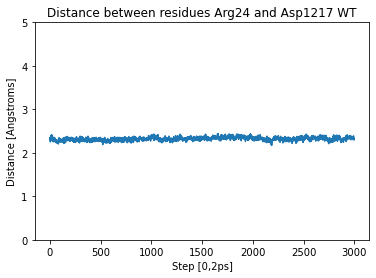

In [23]:
plt.plot(distance(atom1.index, atom2.index))

plt.ylim(0.5,1.5)
plt.ylabel('Distance [10¹ Angstroms]')
plt.xlabel('Steps [0,2ps]')
plt.title('Distance between residues X and Y')

axes = plt.gca()
y_min, y_max = axes.get_ylim()
print(y_min, y_max)